<a href="https://colab.research.google.com/github/seregamikhailov/Credit-scoring/blob/main/Credit_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit scoring.
Dataset from Kaggle. pet - Project

# Import data + libraries


In [46]:
!pip install catboost

In [135]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder


from torch.utils.data import DataLoader,TensorDataset
import torch.nn.functional as F


from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score,log_loss,recall_score,f1_score,precision_score,roc_curve, auc

RAND = 10

In [48]:
data = pd.read_csv('/content/bank.csv',sep = ';')
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [49]:
sum(data.isna().sum())

0

In [50]:
data = data.drop(columns = ['day','month'],axis = 1)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   duration   4521 non-null   int64 
 10  campaign   4521 non-null   int64 
 11  pdays      4521 non-null   int64 
 12  previous   4521 non-null   int64 
 13  poutcome   4521 non-null   object
 14  y          4521 non-null   object
dtypes: int64(6), object(9)
memory usage: 529.9+ KB


In [52]:
data.describe()

,age,balance,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,3025.000000,50.000000,871.000000,25.000000


In [53]:
data.nunique()

,0
age,67
job,12
marital,3
education,4
default,2
balance,2353
housing,2
loan,2
contact,3
duration,875


In [54]:
data.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,4,2
top,management,married,secondary,no,yes,no,cellular,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,3705,4000


In [55]:
data['job'].nunique()

12

# Exploring data analysis



my hypotheses:
1. People with job status “unemployed” most likely not receive a credit;
2. People with loan status 'yes' mots likely not receive a credit;
3. People with negative balance most likely not receive a credit;


# Loan


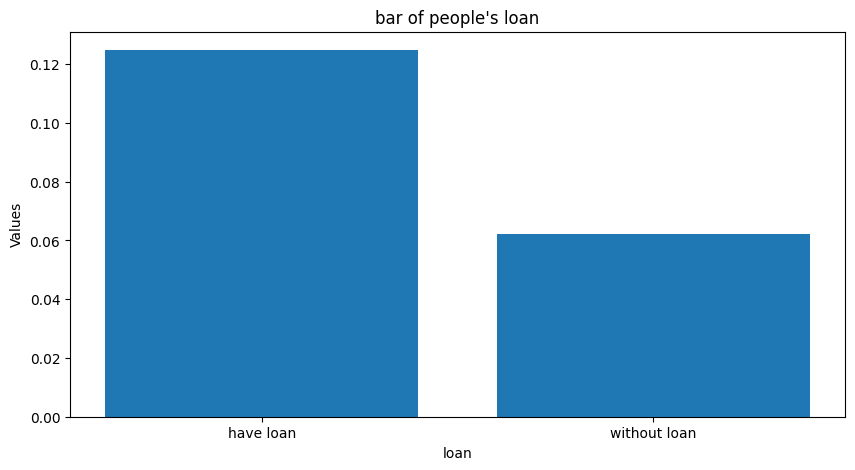

In [56]:
data[data['loan']=='no']['y'].value_counts()
people_without_loan = len(data[(data['loan'] == 'no')&(data['y']=='yes')]['y'].values)/(len(data[(data['loan']=='no')]['y'].values))
people_have_loan = len(data[(data['loan'] == 'yes')&(data['y']=='yes')]['y'].values)/(len(data[(data['loan']=='yes')]['y'].values))
plt.figure(figsize = (10,5))
plt.bar(['have loan','without loan'],[people_without_loan,people_have_loan])
plt.xlabel('loan')
plt.ylabel('Values')
plt.title('bar of people\'s loan')
plt.show()

my first hypothesis is confirmed, people who have loans are unlikely to get a credit

# Jobs

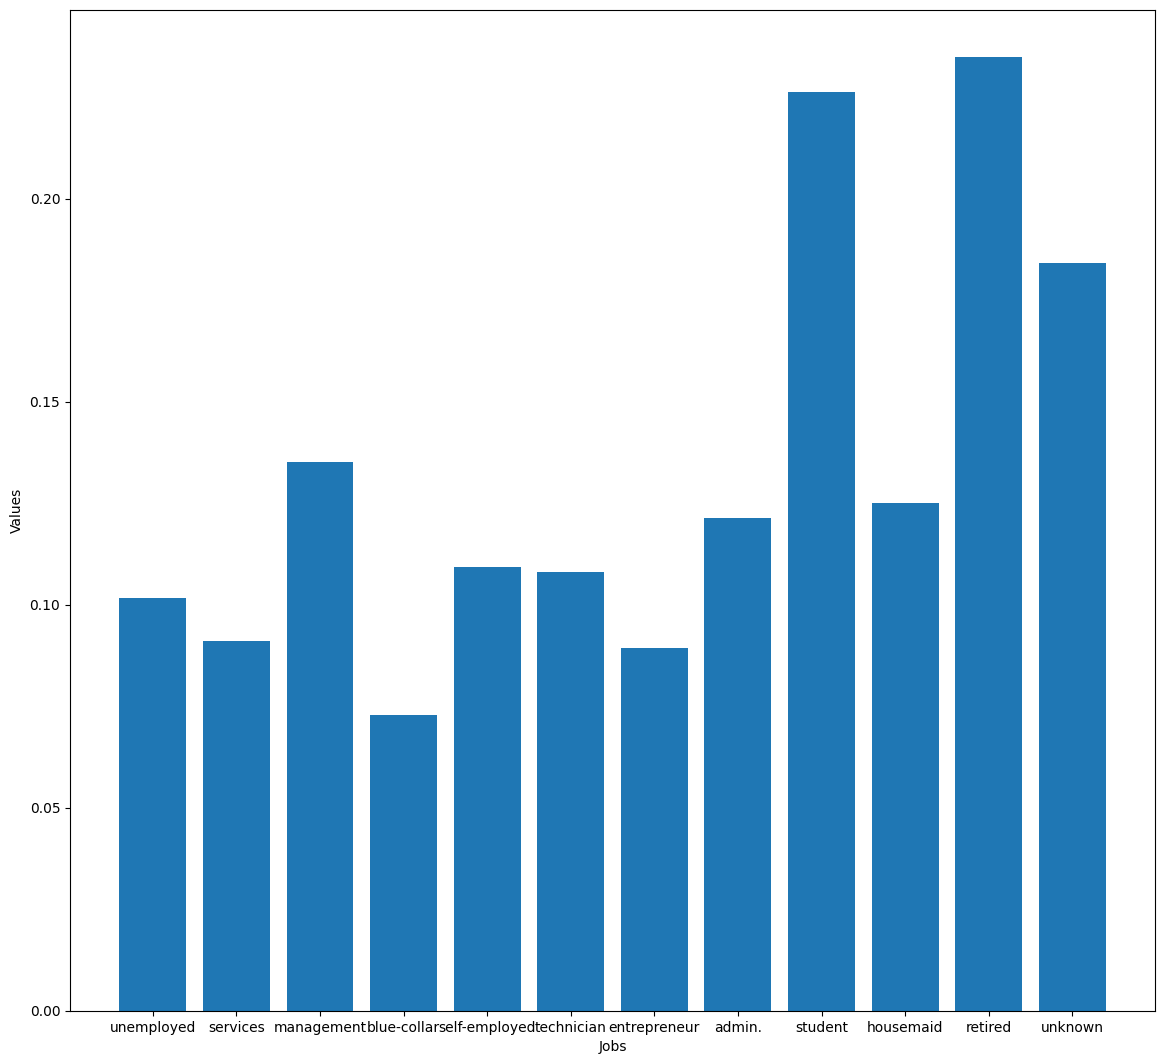

In [57]:
array_of_jobs = data['job'].unique()
dict_of_percent_jobs = {}
for i in array_of_jobs:
  dict_of_percent_jobs[i] = len(data[(data['job'] == i)&(data['y']=='yes')]['y'].values)/(len(data[(data['job'] == i)]['y'].values))
keys = list(dict_of_percent_jobs.keys())
values = list(dict_of_percent_jobs.values())
plt.figure(figsize = (14,13))
plt.bar(keys,values)
plt.xlabel('Jobs')
plt.ylabel('Values')
plt.title('')
plt.show()

the second hypothesis is almost confirmed
on average, unemployed people are less likely to get a credit

#Balance

In [58]:
data.groupby('y')['balance'].median()

,balance
y,
no,419.5
yes,710.0


In [59]:
data.groupby('y')['balance'].mean()

,balance
y,
no,1403.211750
yes,1571.955854


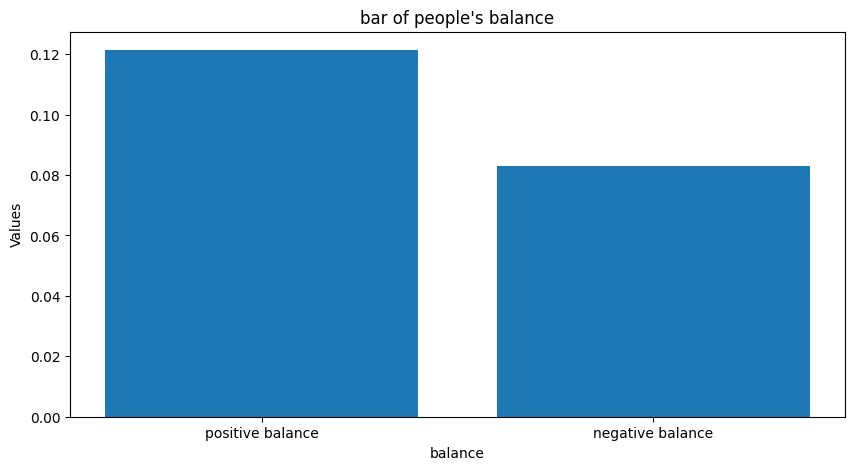

In [60]:
people_balance_positive_balance = len(data[(data['balance'] > 0)&(data['y']=='yes')]['y'].values)/(len(data[(data['balance']>0)]['y'].values))
people_balance_negative_balance = len(data[(data['balance'] <= 0)&(data['y']=='yes')]['y'].values)/(len(data[(data['balance']<=0)]['y'].values))
plt.figure(figsize = (10,5))
plt.bar(['positive balance','negative balance'],[people_balance_positive_balance,people_balance_negative_balance])
plt.xlabel('balance')
plt.ylabel('Values')
plt.title('bar of people\'s balance')
plt.show()

third hypothese approved
people with positive balance have more chances to get a credit

#Corr

<Axes: >

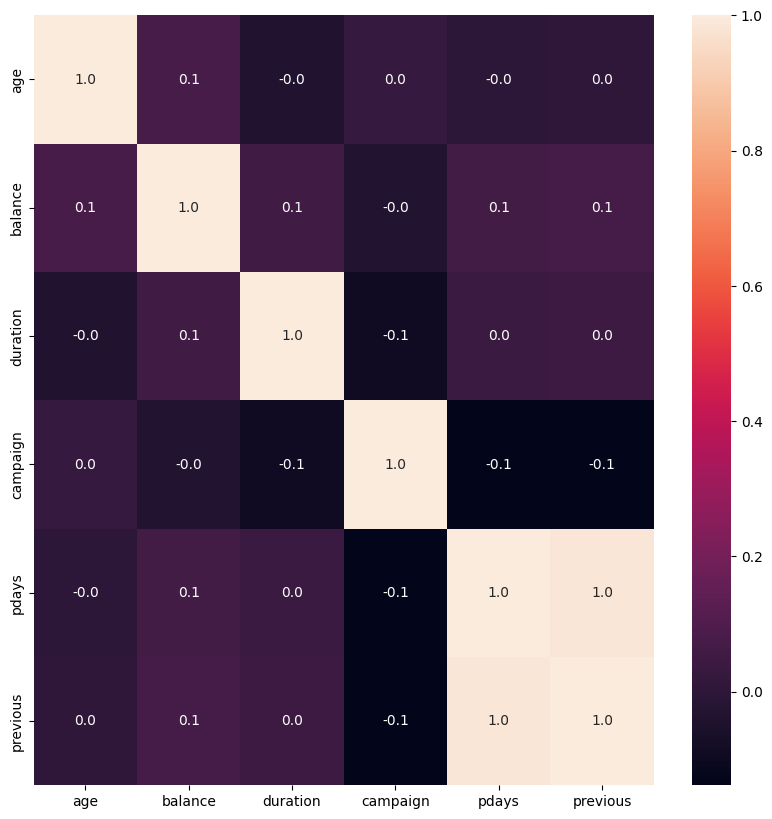

In [61]:
plt.figure(figsize = [10,10])
sns.heatmap(data[data.select_dtypes(exclude = 'object').columns].corr(method = 'spearman'),annot = True,fmt = ".1f")

In [62]:
data = data.drop(columns= ['pdays'])

<Axes: >

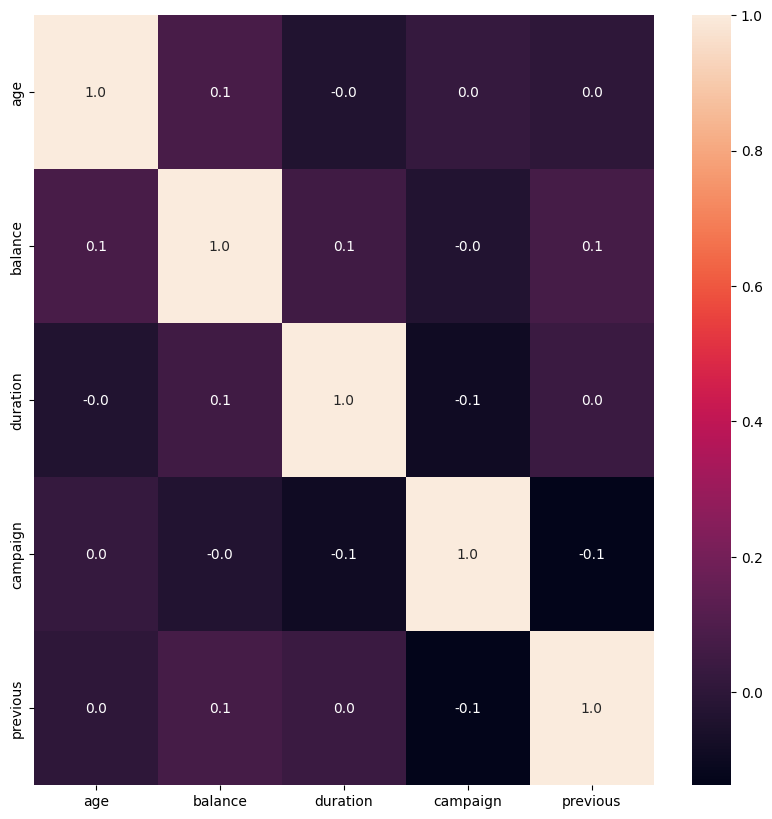

In [63]:
plt.figure(figsize = [10,10])
sns.heatmap(data[data.select_dtypes(exclude = 'object').columns].corr(method = 'spearman'),annot = True,fmt = ".1f")

# Feature engineering

In [64]:
y = data['y']
data = data.drop(columns = ['y'])
y = y.replace(['no','yes'],['0','1'])
y = y.astype(int)

In [65]:
data_columns_num = data.select_dtypes(exclude = ['object']).columns.tolist()
data_columns_cat = data.select_dtypes(include = ['object']).columns.tolist()

<ipython-input-66-65d92ae36fe6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_plot = sns.distplot(data['age'])


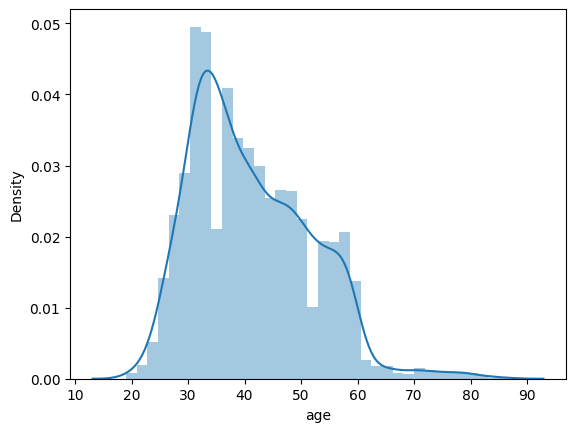

In [66]:
sns_plot = sns.distplot(data['age'])

Text(0.5, 0.98, 'Histograms of various features')

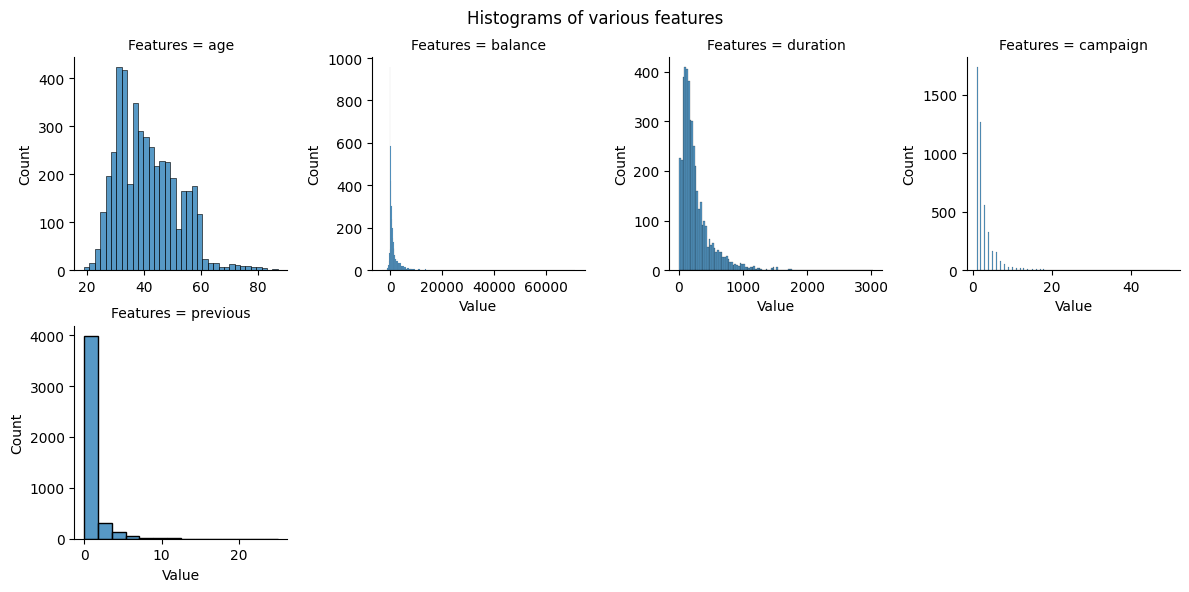

In [67]:
numeric_features = data[data_columns_num]
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
numeric_features
ax = sns.FacetGrid(data = numeric_features,col = "Features",col_wrap = 4,sharex = False,sharey=False)
ax = ax.map(sns.histplot,"Value")
plt.subplots_adjust(top = 0.9)
plt.suptitle("Histograms of various features")

In [68]:
for i in ['duration','campaign','previous']:
  data[i] = np.log(data[i]+1)

In [69]:
# for i in ['balance','duration','campaign','previous']:
#   data[i] = np.cbrt(data[i])

Text(0.5, 0.98, 'Histograms of various features')

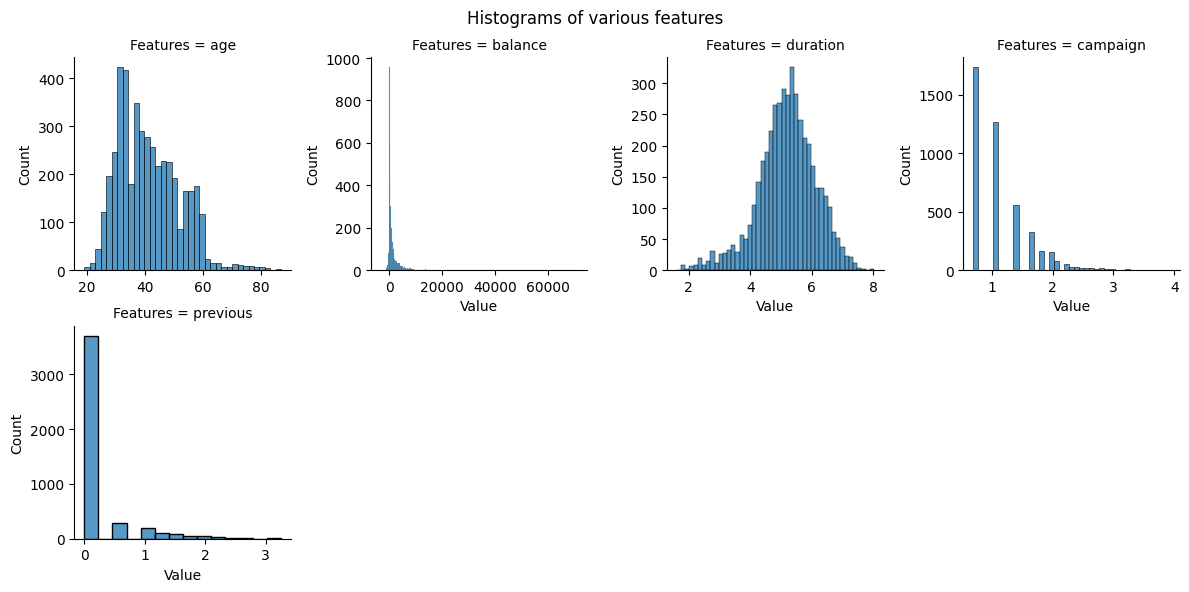

In [70]:
numeric_features = data[data_columns_num]
numeric_features = numeric_features.stack().reset_index().rename(columns = {"level_1":"Features",0:"Value"})
numeric_features
ax = sns.FacetGrid(data = numeric_features,col = "Features",col_wrap = 4,sharex = False,sharey=False)
ax = ax.map(sns.histplot,"Value")
plt.subplots_adjust(top = 0.9)
plt.suptitle("Histograms of various features")

In [71]:
# new feature
mean_income_age = data.groupby('age')['balance'].median().to_dict()
data['mean_income_age'] = data['age'].map(mean_income_age)


<Axes: >

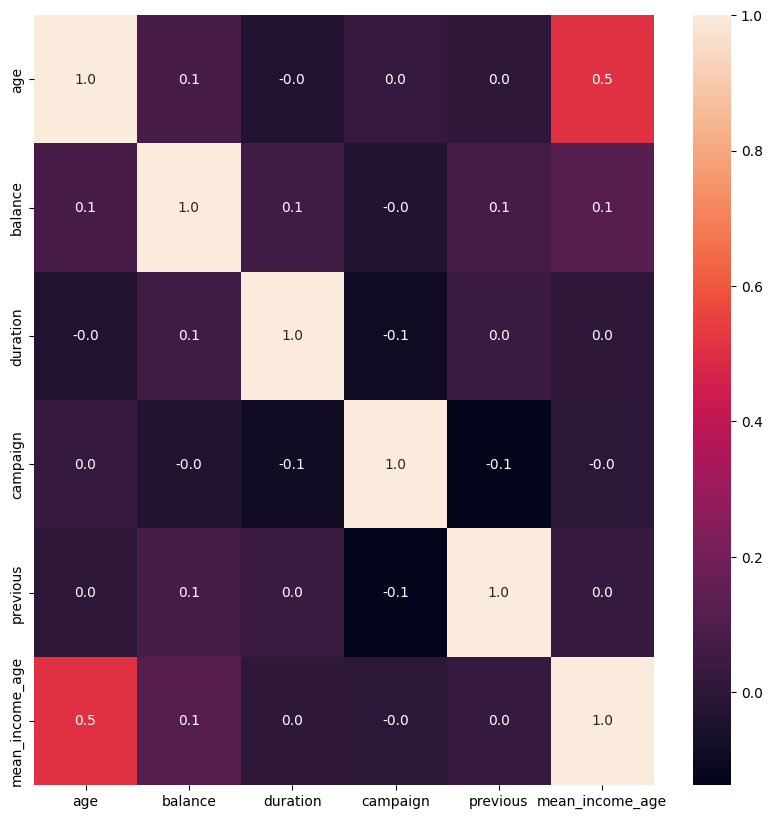

In [72]:
plt.figure(figsize = [10,10])
sns.heatmap(data[data.select_dtypes(exclude = 'object').columns].corr(method = 'spearman'),annot = True,fmt = ".1f")

In [73]:
encoder = OneHotEncoder(handle_unknown='ignore',drop = 'first',sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[data_columns_cat])


In [74]:
df_one_hot_encoded = pd.DataFrame(one_hot_encoded,columns=encoder.get_feature_names_out(data_columns_cat))
X = pd.concat([data,df_one_hot_encoded],axis = 1)
X = X.drop(data_columns_cat,axis = 1)

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,stratify = y,shuffle = True,random_state=RAND)

#Baseline

In [83]:
model = LogisticRegression(random_state = RAND,class_weight='balanced',solver='lbfgs', max_iter=10000 ).fit(X_train,y_train)
y_pred = model.predict(X_test)

y_score = model.predict_proba(X_test)[:,1]

In [86]:
print("roc_auc_score: ",roc_auc_score(y_test,y_score))
print("precision: ", precision_score(y_test,y_pred))
print("recall ", recall_score(y_test,y_pred))
print("f1: ", f1_score(y_test,y_pred))
print("log_loss: ",log_loss(y_test,y_pred))

roc_auc_score:  0.8624221931914239
precision:  0.311178247734139
recall  0.7923076923076923
f1:  0.44685466377440347
log_loss:  8.126553151392464


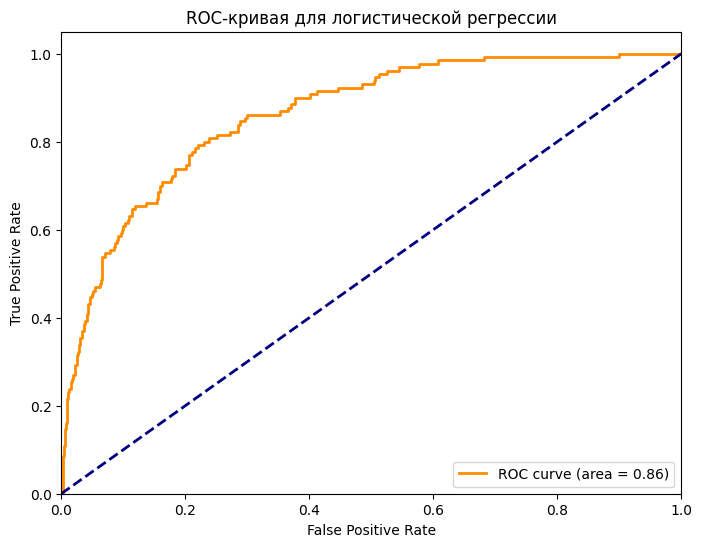

In [87]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для логистической регрессии')
plt.legend(loc="lower right")
plt.show()

In [88]:
metrics = pd.DataFrame(index = ['roc_auc','precision','recall','f1','log_loss'])
metrics['Logreg(BaseLine)'] = [roc_auc_score(y_test,y_score),precision_score(y_test,y_pred),recall_score(y_test,y_pred), f1_score(y_test,y_pred),log_loss(y_test,y_pred)]
metrics

,Logreg(BaseLine)
roc_auc,0.862422
precision,0.311178
recall,0.792308
f1,0.446855
log_loss,8.126553


#Grid_search

In [89]:
params_grid_search = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'max_iter': [100, 500, 1000]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.7],
        'max_iter': [100, 500, 1000]
    }
]
grid_cv = GridSearchCV(model, param_grid=params_grid_search,cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [90]:
grid_cv.fit(X_train,y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=10),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'max_iter': [100, 500, 1000], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.1, 0.5, 0.7],
                          'max_iter': [100, 500, 1000],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='accuracy', verbose=1)

In [91]:
print(grid_cv.best_params_)

{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [92]:
print(grid_cv.best_score_)

0.8017699115044248


In [97]:
model_grid = LogisticRegression(C =  1.0, max_iter =  100, penalty =  'l1', solver =  'liblinear',class_weight='balanced')
model_grid.fit(X_train,y_train)
y_pred_grid = model_grid.predict(X_test)
y_score_grid = model_grid.predict_proba(X_test)[:,1]


In [98]:
print("roc_auc_score: ",roc_auc_score(y_test,y_score_grid))
print("precision: ", precision_score(y_test,y_pred_grid))
print("recall ", recall_score(y_test,y_pred_grid))
print("f1: ", f1_score(y_test,y_pred_grid))
print("log_loss: ",log_loss(y_test,y_pred_grid))

roc_auc_score:  0.8686621071236456
precision:  0.3149847094801223
recall  0.7923076923076923
f1:  0.45076586433260396
log_loss:  7.999077807841206


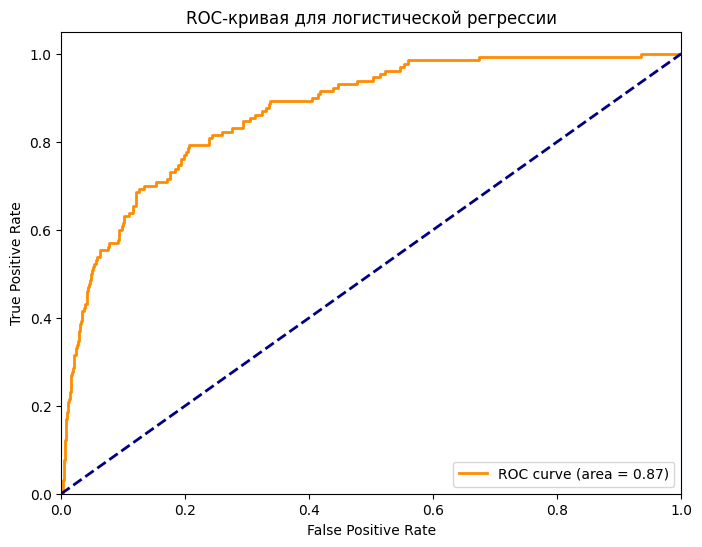

In [99]:
fpr, tpr, thresholds = roc_curve(y_test, y_score_grid)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC-кривая для логистической регрессии')
plt.show()

In [100]:
metrics['Logreg(GridSearch)'] = [roc_auc_score(y_test,y_score_grid),precision_score(y_test,y_pred_grid),recall_score(y_test,y_pred_grid), f1_score(y_test,y_pred_grid),log_loss(y_test,y_pred_grid)]
metrics

,Logreg(BaseLine),Logreg(GridSearch)
roc_auc,0.862422,0.868662
precision,0.311178,0.314985
recall,0.792308,0.792308
f1,0.446855,0.450766
log_loss,8.126553,7.999078


#CatBoost

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              4521 non-null   int64  
 1   job              4521 non-null   object 
 2   marital          4521 non-null   object 
 3   education        4521 non-null   object 
 4   default          4521 non-null   object 
 5   balance          4521 non-null   int64  
 6   housing          4521 non-null   object 
 7   loan             4521 non-null   object 
 8   contact          4521 non-null   object 
 9   duration         4521 non-null   float64
 10  campaign         4521 non-null   float64
 11  previous         4521 non-null   float64
 12  poutcome         4521 non-null   object 
 13  mean_income_age  4521 non-null   float64
dtypes: float64(4), int64(2), object(8)
memory usage: 494.6+ KB


In [102]:
data
cat_features_id = [1,2,3,4,6,7,8,12]

In [103]:
y

,y
0,0
1,0
2,0
3,0
4,0
...,...
4516,0
4517,0
4518,0
4519,0


In [104]:
X_train.isna().sum().sum()

0

In [105]:
X_train_boost,X_test_boost,y_train_boost,y_test_boost = train_test_split(data,y,test_size=0.25,shuffle=True,stratify = y,random_state = RAND)
model_catboost = CatBoostClassifier()
model_catboost.fit(X_train_boost,y_train_boost,cat_features_id)
y_pred_boost = model_catboost.predict(X_test_boost)
y_pred_boost_proba = model_catboost.predict_proba(X_test_boost)[:,1]

Learning rate set to 0.017351
0:	learn: 0.6750262	total: 59.9ms	remaining: 59.8s
1:	learn: 0.6542494	total: 68.4ms	remaining: 34.1s
2:	learn: 0.6362881	total: 77.1ms	remaining: 25.6s
3:	learn: 0.6194677	total: 84.9ms	remaining: 21.1s
4:	learn: 0.6034745	total: 93.3ms	remaining: 18.6s
5:	learn: 0.5897706	total: 98.3ms	remaining: 16.3s
6:	learn: 0.5742587	total: 106ms	remaining: 15.1s
7:	learn: 0.5595954	total: 113ms	remaining: 14s
8:	learn: 0.5496594	total: 117ms	remaining: 12.8s
9:	learn: 0.5356044	total: 125ms	remaining: 12.3s
10:	learn: 0.5238500	total: 132ms	remaining: 11.9s
11:	learn: 0.5118008	total: 140ms	remaining: 11.5s
12:	learn: 0.4988488	total: 149ms	remaining: 11.3s
13:	learn: 0.4879989	total: 154ms	remaining: 10.9s
14:	learn: 0.4794397	total: 162ms	remaining: 10.6s
15:	learn: 0.4708719	total: 168ms	remaining: 10.3s
16:	learn: 0.4627138	total: 176ms	remaining: 10.2s
17:	learn: 0.4550905	total: 180ms	remaining: 9.8s
18:	learn: 0.4476068	total: 189ms	remaining: 9.76s
19:	lear

In [106]:
print("roc_auc_score: ",roc_auc_score(y_test,y_pred_boost_proba))
print("precision: ", precision_score(y_test,y_pred_boost))
print("recall ", recall_score(y_test,y_pred_boost))
print("f1: ", f1_score(y_test,y_pred_boost))
print("log_loss: ",log_loss(y_test,y_pred_boost))

roc_auc_score:  0.8781372473680167
precision:  0.5681818181818182
recall  0.38461538461538464
f1:  0.45871559633027525
log_loss:  3.7605226347620015


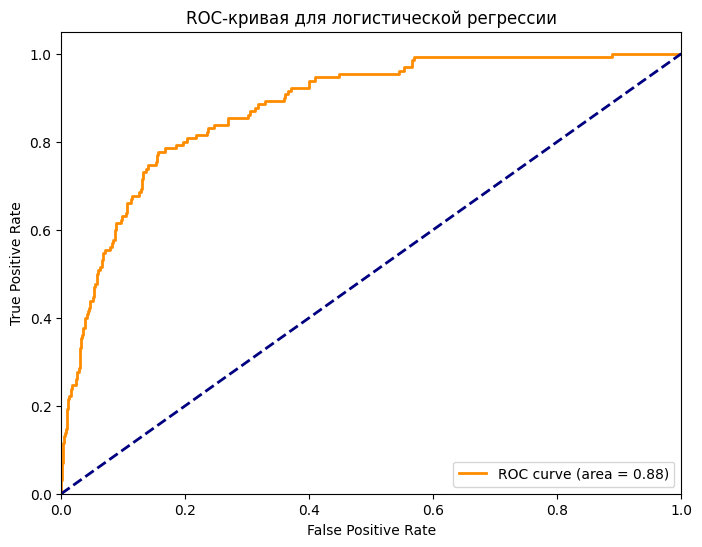

In [107]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_boost_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для логистической регрессии')
plt.legend(loc="lower right")
plt.show()

In [108]:
metrics['CatBoost'] = [roc_auc_score(y_test,y_pred_boost_proba),precision_score(y_test,y_pred_boost),recall_score(y_test,y_pred_boost),f1_score(y_test,y_pred_boost),log_loss(y_test,y_pred_boost)]
metrics

,Logreg(BaseLine),Logreg(GridSearch),CatBoost
roc_auc,0.862422,0.868662,0.878137
precision,0.311178,0.314985,0.568182
recall,0.792308,0.792308,0.384615
f1,0.446855,0.450766,0.458716
log_loss,8.126553,7.999078,3.760523


#fully connected neural network

In [137]:
data_columns_cat = data.select_dtypes(include = ['object']).columns.tolist()
le = LabelEncoder()
for i in data_columns_cat:
  data[i] = le.fit_transform(data[i])

In [138]:
X_train_NN,X_test_NN,y_train_NN,y_test_NN= train_test_split(data,y,test_size = 0.2,random_state=RAND,stratify = y,shuffle = True)

In [139]:
X_train_NN

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,previous,poutcome,mean_income_age
3016,39,9,2,1,0,122,1,0,2,5.068904,0.693147,0.000000,3,370.0
3185,42,0,1,1,0,529,1,1,0,5.267858,1.386294,0.000000,3,360.0
487,52,1,1,0,0,779,1,0,2,3.433987,1.386294,0.000000,3,242.5
1802,30,7,2,1,0,432,1,0,2,5.831882,1.386294,0.000000,3,367.0
1763,57,1,1,1,0,2887,0,0,0,6.709304,2.397895,0.000000,3,282.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,52,1,1,1,0,161,1,0,2,5.616771,1.098612,0.000000,3,242.5
1970,35,9,1,1,0,-259,1,0,0,5.945421,0.693147,1.098612,0,370.5
2552,23,7,1,1,0,-19,1,0,2,2.639057,2.397895,0.000000,3,667.0
539,41,0,1,1,0,920,1,1,2,5.480639,0.693147,0.000000,3,552.0


In [140]:
X_train_NN = torch.tensor(X_train_NN.values,dtype = torch.float32)
X_test_NN = torch.tensor(X_test_NN.values,dtype = torch.float32)
y_train_NN = torch.tensor(y_train_NN.values,dtype = torch.float32)
y_test_NN = torch.tensor(y_test_NN.values,dtype = torch.float32)

In [141]:
batch_size = 128

In [142]:
train_dataset = TensorDataset(X_train_NN,y_train_NN)
test_dataset = TensorDataset(X_test_NN,y_test_NN)
train_loader = DataLoader(train_dataset,batch_size = batch_size,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size = batch_size,drop_last=True)

In [159]:
class Credit_NN(nn.Module):
    def __init__(self):
        super(Credit_NN, self).__init__()
        self.fc1 = nn.Linear(14, 1000)
        self.fc2 = nn.Linear(1000, 700)
        self.fc3 = nn.Linear(700, 700)
        self.fc4 = nn.Linear(700, 500)
        self.fc5 = nn.Linear(500, 300)
        self.fc6 = nn.Linear(300, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        return x
net = Credit_NN()

In [160]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [161]:
epochs = 50
history = []

In [162]:
for i in range(epochs):
  for x_batch,y_batch in train_loader:
    x_batch = x_batch.view(x_batch.shape[0], -1)
    y_batch = y_batch
    logits = np.squeeze(net(x_batch))
    loss = criterion(logits, y_batch)
    history.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


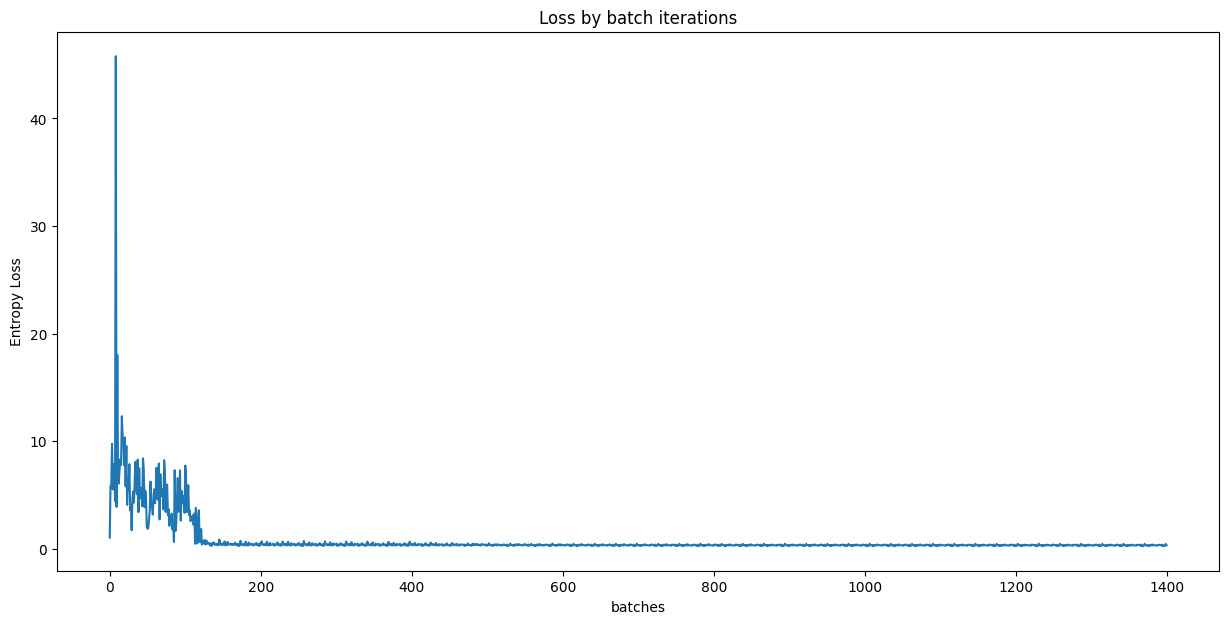

In [163]:
plt.figure(figsize=(15, 7))
plt.plot(history)
plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')
plt.show()

In [164]:
net.eval()
with torch.no_grad():
    predictions = net(X_test_NN).squeeze()
    predictions = predictions.round()
    accuracy = (predictions == y_test_NN).float().mean()
    print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8807
